# Convolutional Neural Network, Keras

In [1]:
import numpy as np
import matplotlib.pyplot as plt # to visualize only
import pandas as pd
from sklearn.model_selection import train_test_split

import keras as ks
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras import backend as K

Using TensorFlow backend.


In [2]:
x = pd.read_csv("./data/processed_x.csv", delimiter=",", header = None)
x = x.values # dataframe to numpy ndarray
x = x.astype(np.float32)
x /= 255 # normalize

In [4]:
y = pd.read_csv("./data/train_y.csv", delimiter = ",", header = None)
y = (y.values).ravel()

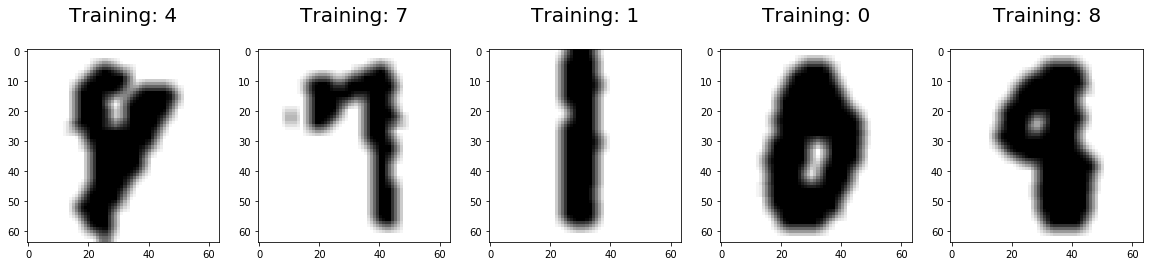

In [5]:
# look at some data for sanity check
def plotter(images, labels, start):
    plt.figure(figsize=(20,4))
    for index, (image, label) in enumerate(zip(images[start:start+5], labels[start:start+5])):
        plt.subplot(1, 5, index + 1)
        plt.imshow(np.reshape(image, (64,64)), cmap= 'gray')
        plt.title('Training: %i\n' % label, fontsize = 20)
plotter(x, y, 0) # first 5 images

In [6]:
# split it on up
np.random.seed(100) # for determinism
x_train, x_valid, y_train, y_valid = train_test_split(
    x, y, test_size=1/10.0, random_state=0)

In [7]:
# set up conv net
batch_size = 128
epochs = 15

num_classes = 10
img_rows, img_cols, = 64, 64

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_valid = x_valid.reshape(x_valid.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_valid = x_valid.reshape(x_valid.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
#y_train = ks.utils.to_categorical(y_train, num_classes)
#y_valid = ks.utils.to_categorical(y_valid, num_classes)

In [8]:
# sanity check that all the shapes of the data are correct
print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(45000, 64, 64, 1)
(5000, 64, 64, 1)
(45000,)
(5000,)


In [13]:
# construct the image generator for data augmentation
img_data_gen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=12,  # randomly rotate images in the range 0 - 20 degrees
            horizontal_flip=False,  # don't flip images
            vertical_flip=False)

In [14]:
img_data_gen.fit(x_train)

In [15]:
# train an encoder to convert labels to integer labels, one-hot encodings, and back
encoder = LabelEncoder().fit(y.reshape((y.shape[0],)))

def encode_onehot(lab):
    return to_categorical(encoder.transform(lab))

def decode_onehot(lab):
    return encoder.inverse_transform(np.argmax(lab, axis = 1))

In [24]:
# ew magic numbers
model = Sequential()
# changing from (3,3) to (2,2)
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=ks.losses.categorical_crossentropy,
              optimizer=ks.optimizers.Adadelta(),
              metrics=['accuracy'])

In [25]:
# go, go, go! go, go speed racer!
model.fit(x_train, encode_onehot(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_valid, encode_onehot(y_valid)))


# model.fit_generator(img_data_gen.flow(x_train, encode_onehot(y_train), batch_size=15),
#         validation_data=(x_valid, encode_onehot(y_valid)), steps_per_epoch=int(len(x_train)/20),
#         epochs=epochs, verbose=1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 17s 367us/step - loss: 1.2500 - acc: 0.5911 - val_loss: 0.5196 - val_acc: 0.8498
Epoch 2/15
45000/45000 [==============================] - 16s 348us/step - loss: 0.6197 - acc: 0.8265 - val_loss: 0.3772 - val_acc: 0.9008
Epoch 3/15
45000/45000 [==============================] - 16s 346us/step - loss: 0.4893 - acc: 0.8694 - val_loss: 0.3372 - val_acc: 0.9114
Epoch 4/15
45000/45000 [==============================] - 16s 345us/step - loss: 0.4274 - acc: 0.8871 - val_loss: 0.3189 - val_acc: 0.9186
Epoch 5/15
45000/45000 [==============================] - 16s 345us/step - loss: 0.3907 - acc: 0.8968 - val_loss: 0.3242 - val_acc: 0.9158
Epoch 6/15
45000/45000 [==============================] - 16s 345us/step - loss: 0.3640 - acc: 0.9044 - val_loss: 0.2937 - val_acc: 0.9222
Epoch 7/15
45000/45000 [==============================] - 16s 346us/step - loss: 0.3426 - acc: 0.9113 - val_loss: 0.2

In [12]:
score = model.evaluate(x_valid, encode_onehot(y_valid), verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2546268650650978
Test accuracy: 0.9364


In [13]:
# testing, 1, 2, testing....
x_test = pd.read_csv("./data/processed_test_x.csv", delimiter=",", header = None)
x_test = x_test.values
x_test = x_test.astype(np.float32)
x_test /= 255
if K.image_data_format() == 'channels_first':
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
else:
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

In [14]:
predictions = model.predict_classes(x_test)
ids = list(range(len(predictions)))

print(predictions[:100])
output = pd.DataFrame({'Id': ids, 'Label': predictions})
output.to_csv("./data/ConvNetPredictions.csv", header = True, index = False)

[7 2 0 7 6 1 5 3 8 1 5 1 9 1 0 2 3 0 0 3 3 0 6 1 6 0 2 8 2 0 2 8 9 1 8 6 0
 1 0 4 0 7 1 1 0 2 3 6 8 4 9 7 3 9 8 2 2 6 5 9 9 9 3 3 8 8 3 8 9 5 2 4 9 4
 8 5 1 8 1 4 9 4 6 8 3 8 1 9 1 6 3 9 0 2 9 3 9 7 2 4]


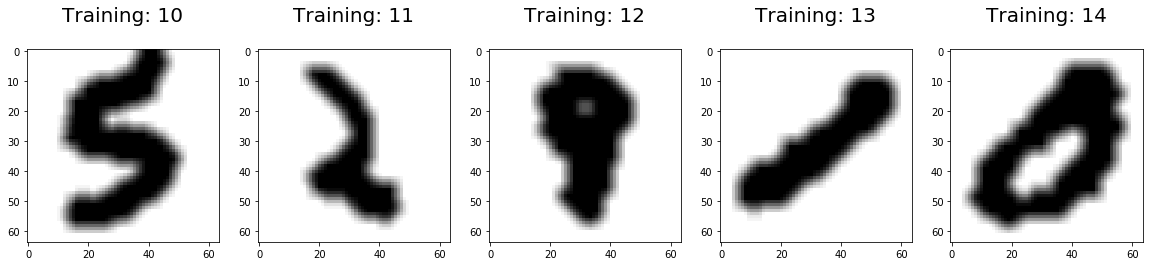

In [18]:
plotter(x_test, ids, 10)